In [194]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

## Config

In [195]:
variant = 6

## Read data

In [196]:
def get_voltage(filename):
  match = re.search(r'[-+]?\d*\.\d+', filename)

  if match:
    return float(match.group())
  else:
    return None

In [197]:
data_dir = 'rawData'

x_time = None
matrix_time = None

voltages = {}

for filename in os.listdir(data_dir):
  file_path = os.path.join(data_dir, filename)

  if not os.path.isfile(file_path):
    continue

  voltage = get_voltage(filename)

  with open(file_path, 'r') as f:
    data = f.read().strip().splitlines()
    data_columns = [line.split(' ') for line in data]
    df = pd.DataFrame(data_columns)
    y = df[variant].to_numpy().astype(float)

    if x_time is None:
      x_time = df[0].to_numpy().astype(float)

    if matrix_time is None:
      matrix_time = y
    else:
      matrix_time = np.vstack((matrix_time, y))

    if not voltage in voltages:
      voltages[voltage] = y
    else:
      voltages[voltage] = np.concatenate((voltages[voltage], y))

x_time.shape, matrix_time.shape

((1024,), (55, 1024))

In [198]:
y_time = matrix_time.mean(axis=0)
y_time.shape

(1024,)

In [199]:
x_voltage = np.array(list(voltages.keys()))
x_voltage.shape

(11,)

In [200]:
y_voltage = np.array([voltages[voltage].mean() for voltage in voltages])
y_voltage.shape

(11,)

## Visualization

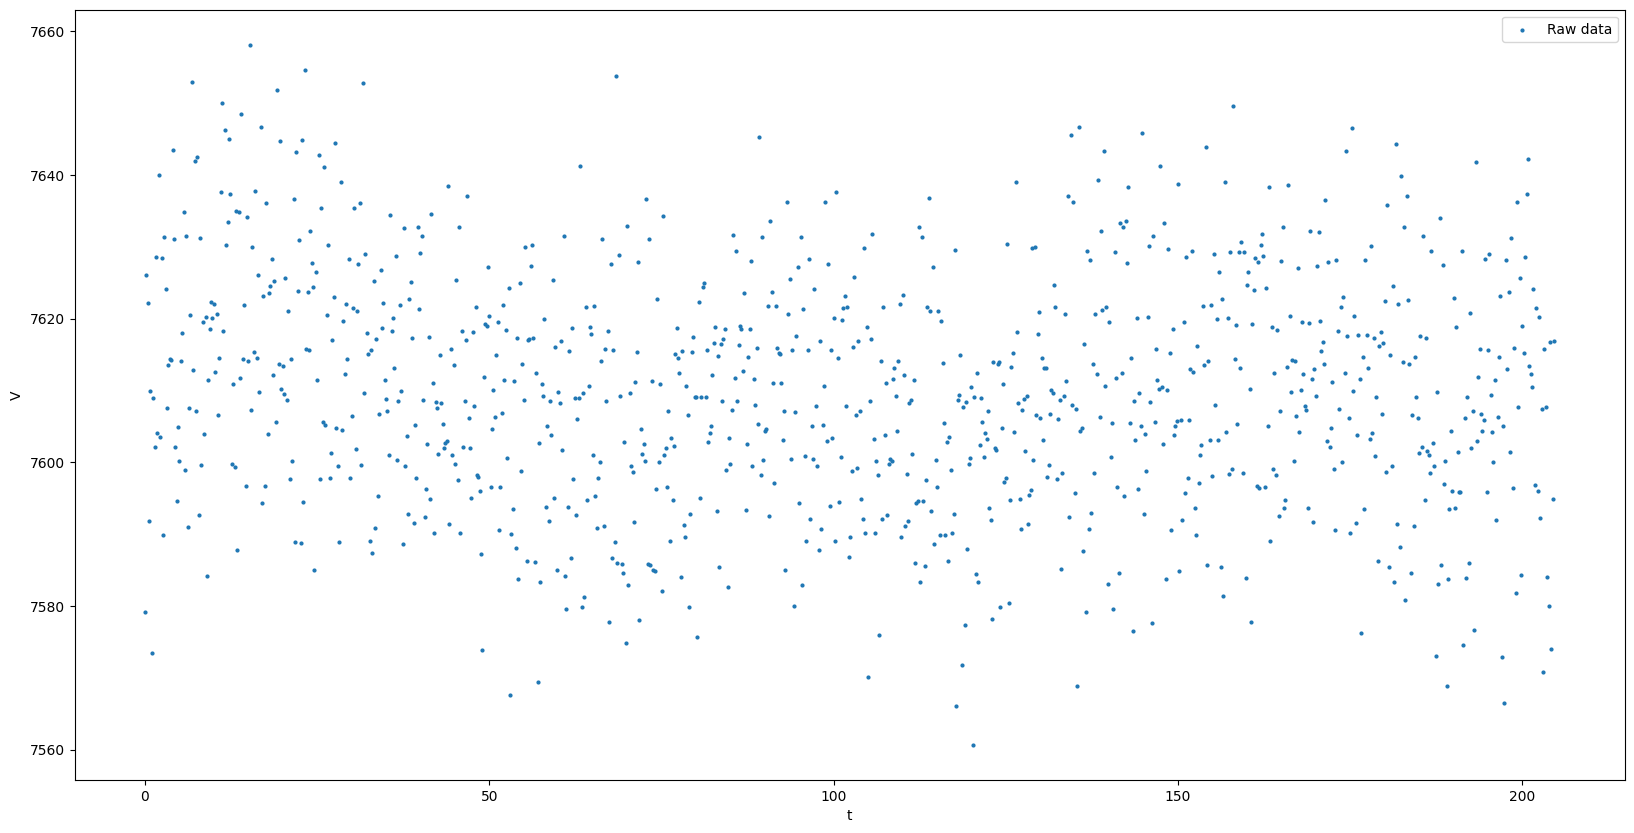

In [201]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time, label='Raw data', s=4)
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

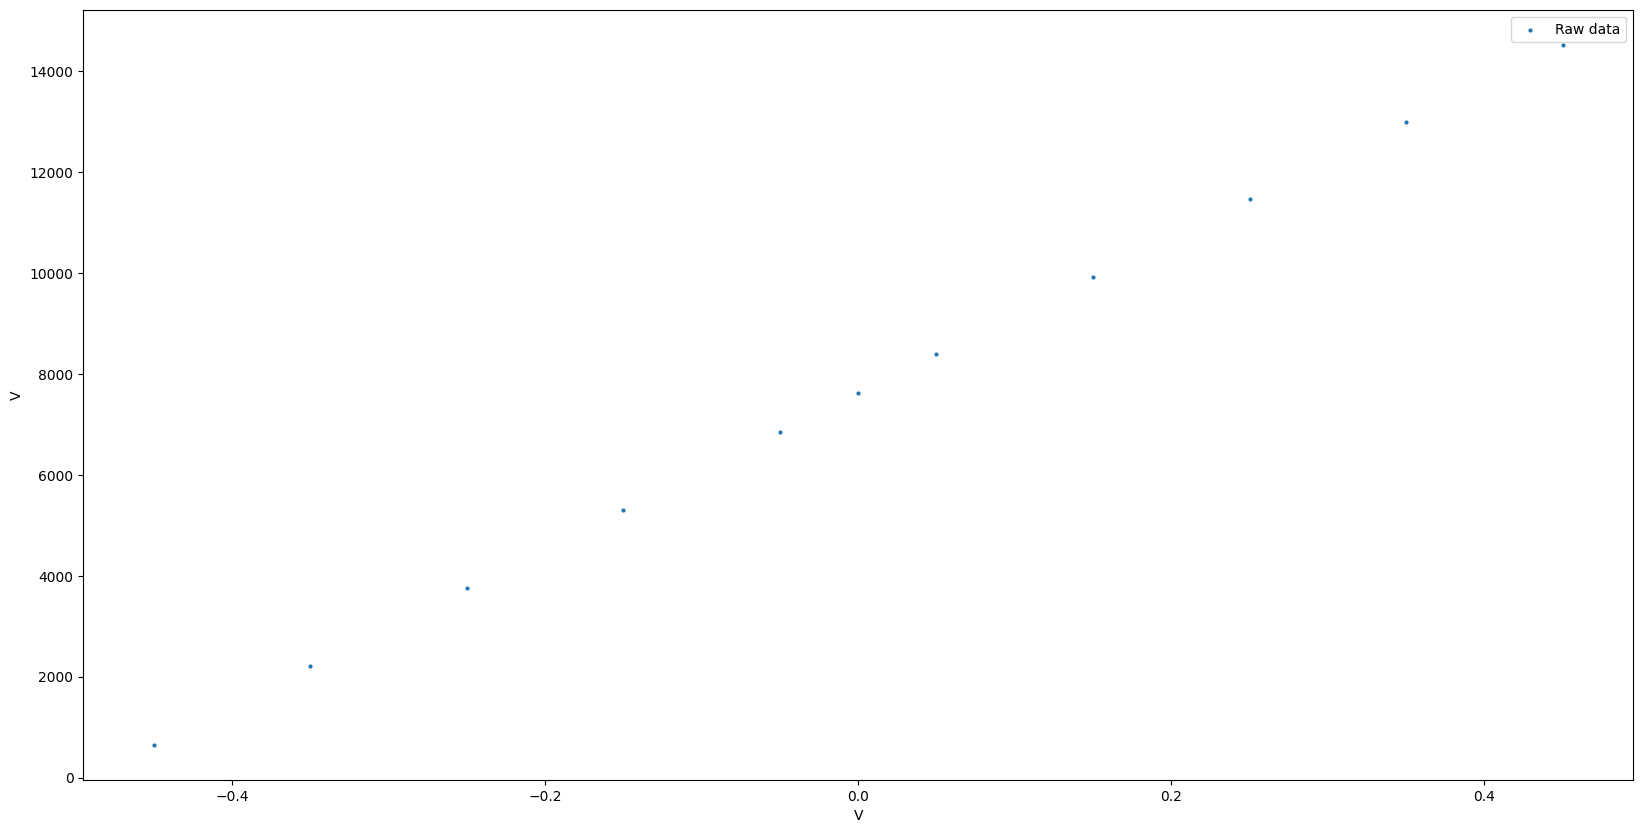

In [202]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage, label='Raw data', s=4)
plt.xlabel('V')
plt.ylabel('V')
plt.legend()

## Linear regression

In [203]:
def mae(params, x, y):
  y_pred = params[0] * x + params[1]
  return np.abs(y - y_pred).mean()

def mse(params, x, y):
  y_pred = params[0] * x + params[1]
  return ((y - y_pred) ** 2).mean()

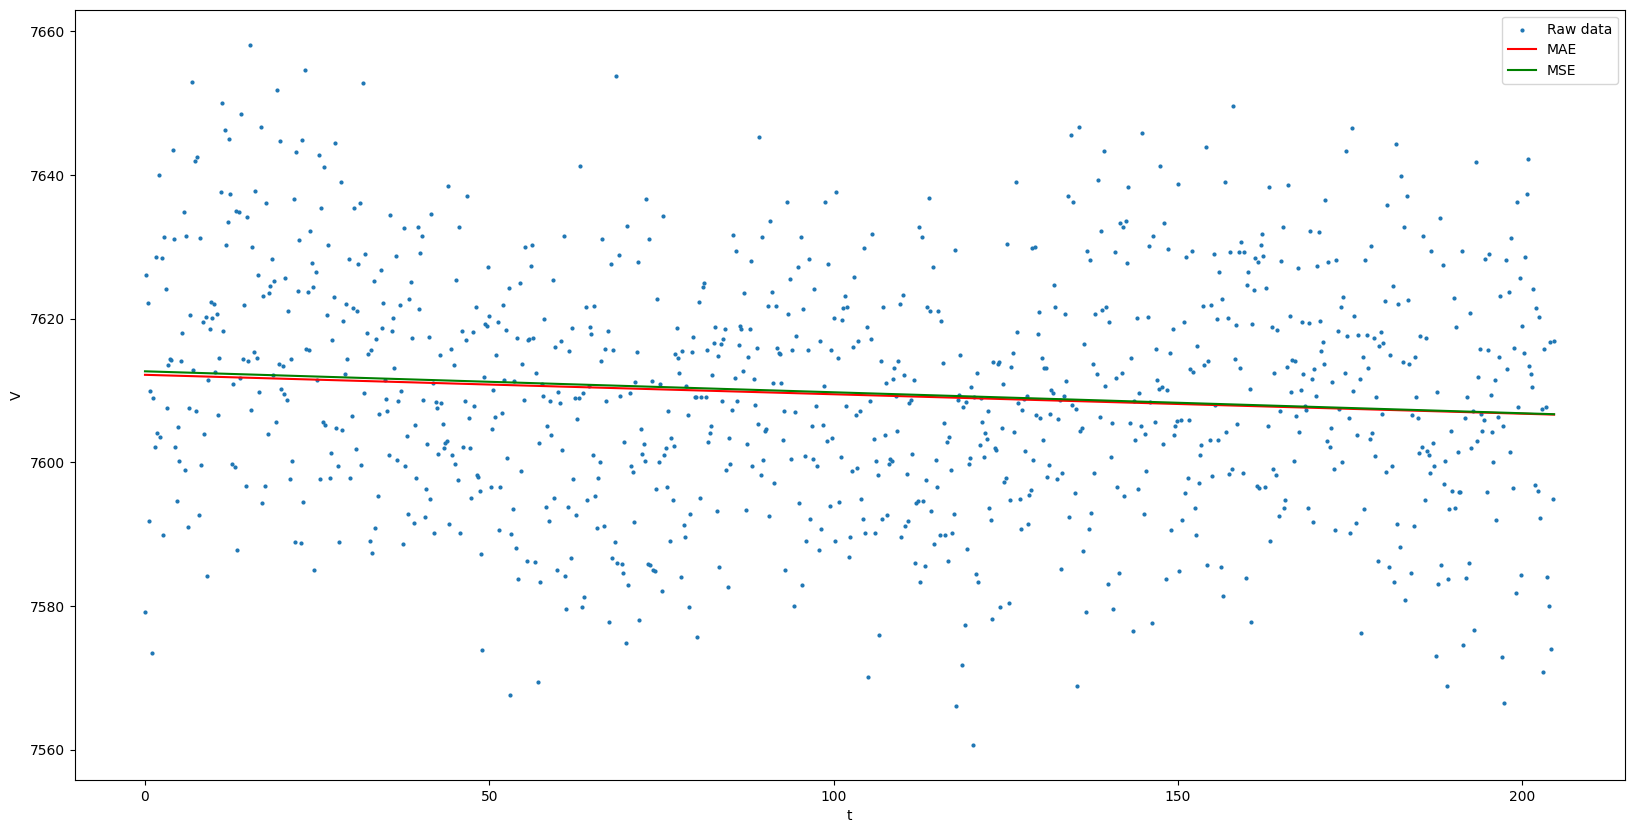

In [204]:
a_abs, b_abs = sp.optimize.minimize(mae, [0, 0], args=(x_time, y_time)).x
a_sq, b_sq = sp.optimize.minimize(mse, [0, 0], args=(x_time, y_time)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time, label='Raw data', s=4)
plt.plot(x_time, x_time * a_abs + b_abs, color='red', label='MAE')
plt.plot(x_time, x_time * a_sq + b_sq, color='green', label='MSE')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

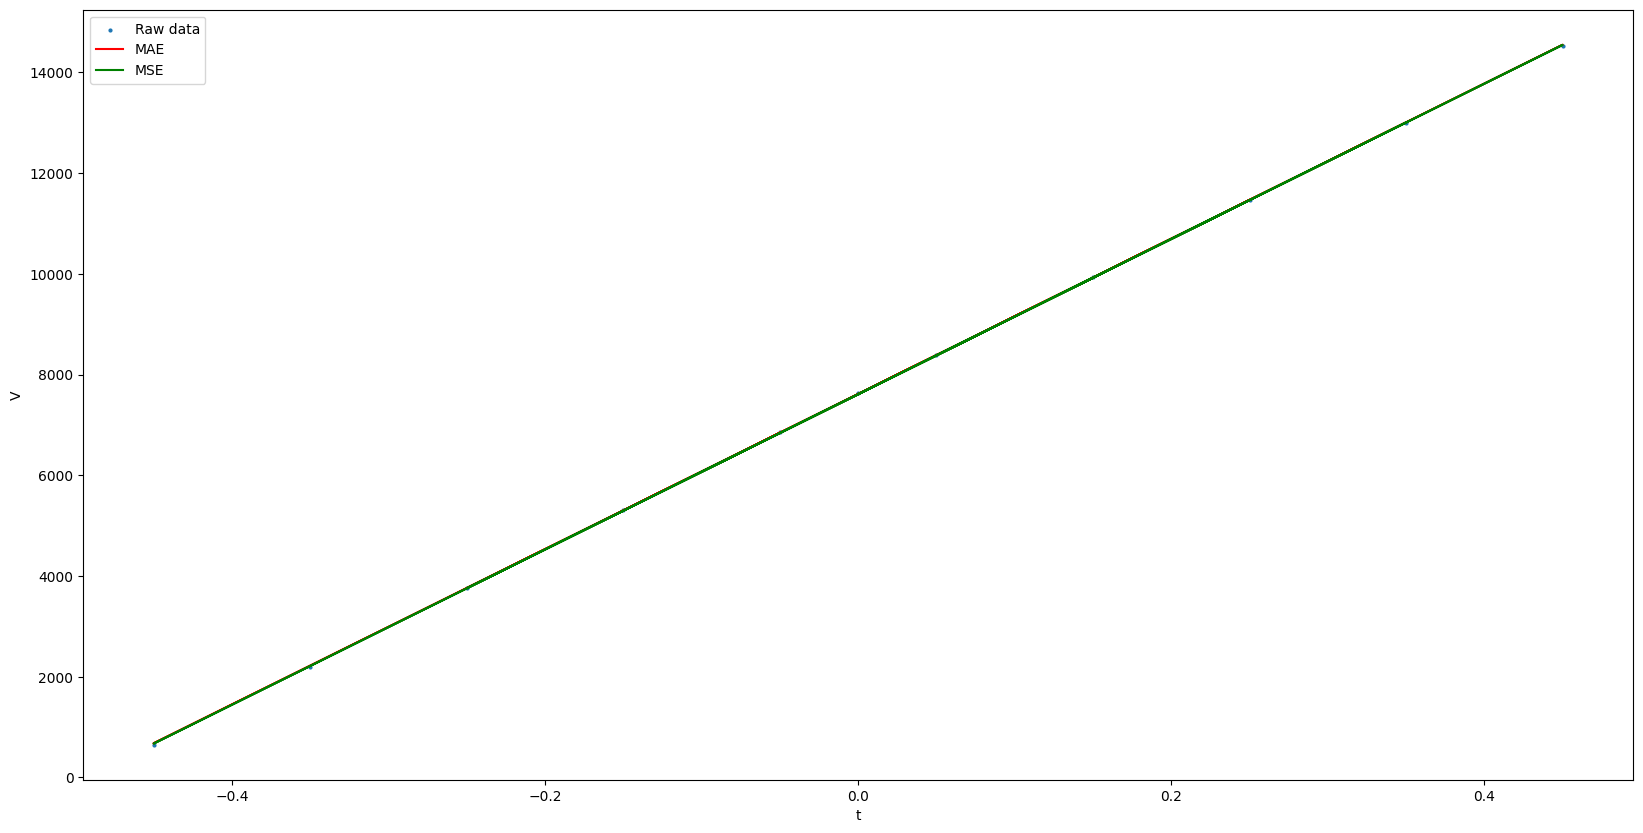

In [205]:
a_abs, b_abs = sp.optimize.minimize(mae, [0, 0], args=(x_voltage, y_voltage)).x
a_sq, b_sq = sp.optimize.minimize(mse, [0, 0], args=(x_voltage, y_voltage)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage, label='Raw data', s=4)
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='MAE')
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='MSE')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

In [206]:
a_abs, b_abs, a_sq, b_sq

(15411.533583000823, 7614.681846345737, 15416.692120227439, 7609.691100802798)

## Non-average

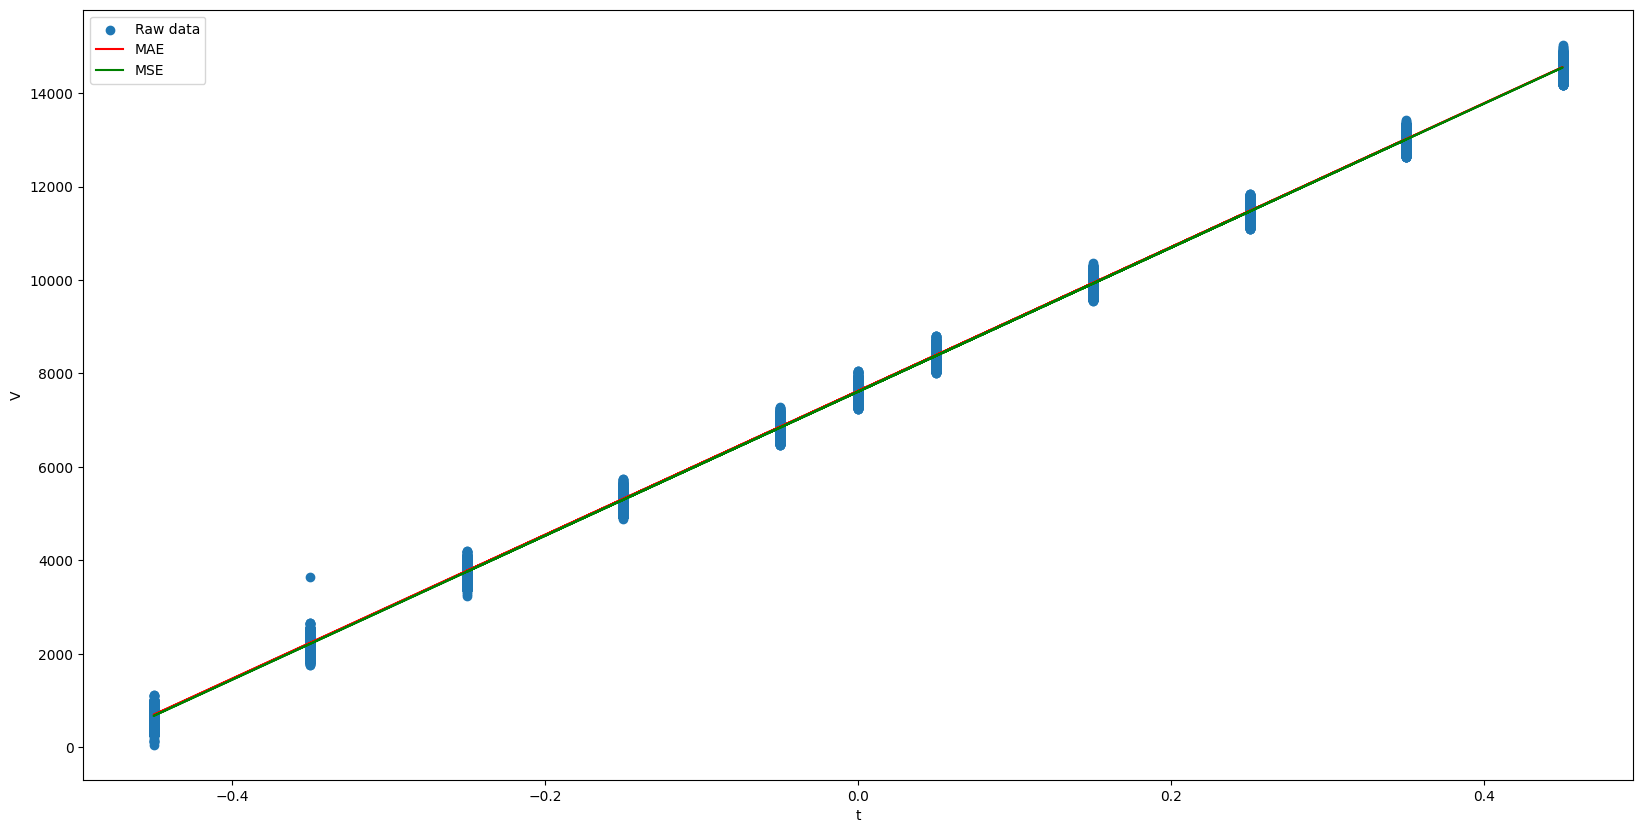

In [209]:
x_voltage_all = np.array([])
y_voltage_all = np.array([])

for voltage, y_voltage_partial in voltages.items():
  x_voltage_partial = np.full(y_voltage_partial.shape, voltage)

  x_voltage_all = np.concatenate((x_voltage_all, x_voltage_partial))
  y_voltage_all = np.concatenate((y_voltage_all, y_voltage_partial))

a_abs, b_abs = sp.optimize.minimize(mae, [0, 0], args=(x_voltage_all, y_voltage_all)).x
a_sq, b_sq = sp.optimize.minimize(mse, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='MAE')
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='MSE')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

## Boxplot

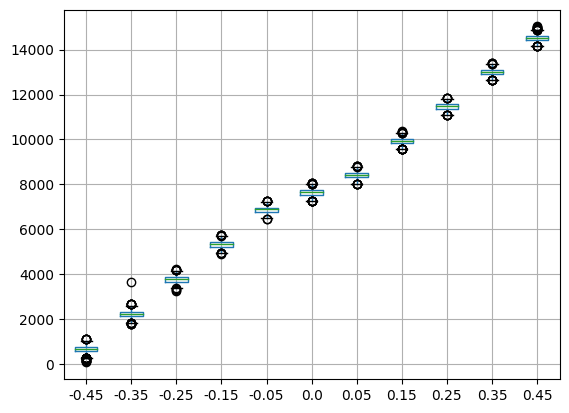

In [207]:
df = pd.DataFrame(voltages, columns=sorted(x_voltage))
boxplot = df.boxplot()

In [ ]:
def filter_out_boxplot(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  return data[(data >= lower_bound) & (data <= upper_bound)]

In [208]:
x_voltage_all = np.array([])
y_voltage_all = np.array([])

for voltage, y_voltage_partial in voltages.items():
  y_voltage_partial = filter_out_boxplot(y_voltage_partial)
  x_voltage_partial = np.full(y_voltage_partial.shape, voltage)


  x_voltage_all = np.concatenate((x_voltage_all, x_voltage_partial))
  y_voltage_all = np.concatenate((y_voltage_all, y_voltage_partial))

a_abs, b_abs = sp.optimize.minimize(mae, [0, 0], args=(x_voltage_all, y_voltage_all)).x
a_sq, b_sq = sp.optimize.minimize(mse, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='MAE')
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='MSE')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

((11,), (11,))